# Exploration  

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from cdlib import viz
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import networkx as nx
#from pyvis import network as net
from cdlib import algorithms, viz
from difflib import get_close_matches
from collections import Counter
from difflib import SequenceMatcher


from statsmodels.stats import diagnostic
from scipy import stats

## Loading CSV files for data story

In [44]:
all_movies = pd.read_csv("./CSV_files/all_movies_metadata.csv")
movie_table = pd.read_csv("./CSV_files/movies_communities_table_scraping_done.csv")
data_movies = pd.read_csv("./CSV_files/movies_communities_metadata_scraping_done.csv")
data_actors = pd.read_csv("./CSV_files/top_20_communities_after_scraping.csv")
community_sizes = pd.read_csv('./CSV_files/community_sizes.csv')
relationships = pd.read_csv('./CSV_files/inter-communities-caracteristics.csv')
features = pd.read_csv('./CSV_files/communities_features.csv')
features_movies = pd.read_csv('./CSV_files/communities_movies_top_features.csv')
features_movies_full = pd.read_csv('./CSV_files/communities_movies_full_features.csv')
gender_rolling = pd.read_csv('./CSV_files/gender_ratio_roll_avg.csv')
age_rolling = pd.read_csv('./CSV_files/average_age_roll_avg.csv')

In [45]:
gender_rolling

,Unnamed: 0,year,Community,actor_gender,ratio,rolling_average_ratio
0,0,1908,1,M,0.680556,NaN
1,1,1908,1,F,0.319444,NaN
2,2,1908,2,M,0.679881,NaN
3,3,1908,2,F,0.320119,NaN
4,4,1908,3,M,0.591413,0.319444
...,...,...,...,...,...,...
4355,4355,2016,18,F,0.480000,0.578947
4356,4356,2016,19,M,0.575758,0.578947
4357,4357,2016,19,F,0.424242,0.578947
4358,4358,2016,20,M,0.578947,0.578947


### Formatting the CSV file

In [46]:
data_movies.drop(['Unnamed: 0'],axis=1,inplace=True)
relationships.drop('Unnamed: 0',axis = 1,inplace = True)

In [47]:
# function that converts the string to a dictionary
def convert_to_dict(string):
    if isinstance(string, str):
        if string == '{}':
            return {}
        else:
            string = string.replace('{', '').replace('}', '').replace('"', '').replace("'",'')
            string = string.split(',')
            string = [x.split(':') for x in string]
            dictionnary = {x[0].strip(): x[1].strip() for x in string}
            return dictionnary

# function that converts the string to a list
def clean_dict(elt):
    if ':' in elt:
        elt = elt[elt.index(':') + 1 : ]
    elt = elt.strip()
    return elt

def convert_to_list(cell):
    if isinstance(cell, str):
        if cell == '{}':
            return []
        if cell == '[]':
            return []
        else:
            cell = cell.replace('[', '').replace(']', '').replace('"', '').replace("'",'')
            cell = cell.replace('{', '').replace('}', '')
            cell = cell.split(',')
            cell = [clean_dict(x) for x in cell]
            return cell


In [48]:
# apply the function to the genres column
data_movies['Movie_genres'] = data_movies['Movie_genres'].apply(convert_to_list)
# apply the same function as Movies_genre to the countries column
data_movies['Movie_countries'] = data_movies['Movie_countries'].apply(convert_to_list)

# apply the function to the language column
data_movies['Movie_languages'] = data_movies['Movie_languages'].apply(convert_to_list)


# apply the function to the genres column
all_movies['Movie_genres'] = all_movies['Movie_genres'].apply(convert_to_list)
# apply the same function as Movies_genre to the countries column
all_movies['Movie_countries'] = all_movies['Movie_countries'].apply(convert_to_list)

# apply the function to the language column
all_movies['Movie_languages'] = all_movies['Movie_languages'].apply(convert_to_list)

In [49]:
for i in range(1,21):
    vars()['datamov' + str(i)]= data_movies[~(data_movies[str(i)] == 0)]

### Dataset of actors merging with actor_metadata (to be removed once properly done)

In [52]:
data_actors = pd.read_csv("./CSV_files/top_20_communities_after_scraping.csv")

In [53]:
character_metadata = pd.read_csv(
    'MovieSummaries/character.metadata.tsv', sep='\t', header=None)
character_metadata.columns = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_release_date', 'Character_name', 'Actor_date_of_birth', 'actor_gender',
                              'Actor_height_(in_meters)', 'Actor_ethnicity', 'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character/actor_map_ID', 'Freebase_character_ID', 'Freebase_actor_ID']


In [54]:
character_metadata.drop_duplicates(subset=['Freebase_actor_ID'],inplace=True)
data_actors = data_actors.merge(character_metadata,left_on='Freebase_actor_ID',right_on='Freebase_actor_ID')
data_actors.drop(['Actor_ethnicity','Freebase_character/actor_map_ID','Freebase_character_ID','Actor_height_(in_meters)',
                    'Character_name','Actor_age_at_movie_release','Wikipedia_movie_ID','Freebase_movie_ID','Movie_release_date'],axis = 1 ,inplace = True)

## Distribution of community sizes

In [55]:
nb_actors_20 = []
for com in range(1,21):
    nb_actors_20.append(len(data_actors[(data_actors['Community'] == com)]))

In [56]:
for i in range(20):
    community_sizes['size'][i]= nb_actors_20[i]

In [58]:
#df = px.data.com_sizes() # iris is a pandas DataFrame
fig = px.scatter(community_sizes, x='community',y='size',
                    title='Number of actors by community',log_x=True,log_y=True,labels=('Community label','Number of actors'),
                    template= 'plotly_white',color_discrete_sequence=['darkblue'])
fig.show()
#fig.write_html('C:/Users/Public/ADA2022/weloic.github.io/_includes/community_sizes_scatter.html')

## Number of movies by communities

In [367]:
nb_movie = []
for com in range(1,21):
    nb_movie.append(len(data_movies[~(data_movies[str(com)] == 0)]))

In [59]:
abs_trace = go.Scatter(mode="lines+markers", x=[*range(1,21)],y=nb_movie,marker = {'size':10,'color':'blue'},line={'width':2,'dash':'dot'})
ratio_trace = go.Scatter(mode="lines+markers", x=[*range(1,21)],y=[i / j for i, j in zip(nb_movie, nb_actors_20)], 
                        marker = {'size':6,'color':'gold','symbol':'x'},line={'width':1,'dash':'dot'})

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(ratio_trace,secondary_y= True)
fig.add_trace(abs_trace)

fig.update_layout( title_text="Movies by community",template = 'plotly_white')
fig.update_layout(yaxis=dict(title="Movies number", titlefont=dict(color="blue"), tickfont=dict(color="blue")),
                    yaxis2=dict(title="Average movies by actor",overlaying="y", side="right", titlefont=dict(color="gold"),position=0.15,tickfont=dict(color="gold")),
                    showlegend = False)

fig.show()
#fig.write_html('C:/Users/Public/ADA2022/weloic.github.io/_includes/movies_community_scatter.html')

## Community features

In [60]:
# each country gets its own trace so that it will have a different color
c1 = features.pivot_table(index='Community',columns='1st_country',values='1st_country_%').fillna(0)
c2 = features.pivot_table(index='Community',columns='2nd_country',values='2nd_country_%').fillna(0)
c3 = features.pivot_table(index='Community',columns='3rd_country',values='3rd_country_%').fillna(0)
countries = c2.add(c1,fill_value=0).add(c3,fill_value=0)
countries.drop('0',axis=1,inplace=True)
countries['Others'] = countries.apply(lambda x: 100 - sum(x),axis=1)

In [61]:
# each occupation gets its own trace so that it will have a different color
o1 = features.pivot_table(index='Community',columns='1st_occupation',values='1st_occupation_%').fillna(0)
o2 = features.pivot_table(index='Community',columns='2nd_occupation',values='2nd_occupation_%').fillna(0)
o3 = features.pivot_table(index='Community',columns='3rd_occupation',values='3rd_occupation_%').fillna(0)
occupations = o2.add(o1,fill_value=0).add(o3,fill_value=0)
occupations['Others'] = occupations.apply(lambda x: 100 - sum(x),axis=1)

In [62]:
countries.columns

Index(['Australia', 'Bhutan', 'Canada', 'China', 'Egypt', 'France', 'Germany',
       'Hong Kong', 'India', 'Ireland', 'Italy', 'Japan', 'Netherlands',
       'Pakistan', 'Portugal', 'Spain', 'Sweden', 'Taiwan', 'United Kingdom',
       'United States of America', 'Others'],
      dtype='object')

In [63]:
# color dictionnary for the interactive plot
# colors are grouped by continent 
color_dict={
    'female_%':'#e97030',
    'male_%':'#3E4E58', #Lime spruce

    'Others' : 'beige',

    'United Kingdom' : '#FC3B01', #Vermillion
    'Australia' : '#FEEFB1', #Buttermilk
    'Canada': '#FF4B2F' , # red orange
    'United States of America': '#FF8E43', #coral
    
    'India' : '#f2e938', #confetti
    'Bhutan' : '#F9DB31', #bright sun
    'Pakistan': 'gold',

    'China' : ' #9CE692', #granny smith green
    'Japan' : '#C1E522', #pear
    'Taiwan' : '#68ce7f', 
    'Hong Kong' : ' #ABEF52', #Sulu

    'Egypt' : '#E6EB59',

    'Ireland': '#264653', 
    'Italy' : '#298880', #Celadon green
    'France': '#287271', #Skobeloff
    'Germany':'#5a8aa6',
    'Netherlands': 'navy',
    'Portugal' : '#D3E7D7', #surf crest
    'Spain': '#3B464E', #lime spruce
    'Sweden' : '#264653', #charcoal 


    'writer' : '#636EFA',
    'voice actor' : '#EF553B',
    'producer': '#00CC96',
    'musician'  :  '#AB63FA',
    'model' :  '#FFA15A',
    'director' : '#19D3F3',
    'comedian' :'#FF6692',
    'seiyū': '#B6E880',
    '2' : '#FF97FF',
    '3': '#FECB52'


}

In [64]:
fig = make_subplots(rows=1, cols=3,shared_yaxes=True,subplot_titles=('Gender (%)','Nationality  (%)','Occupation (%)'))

fig.add_trace(go.Bar( x=features['Males_%'], y=features['Community'],orientation='h',name = 'male',marker={'color':color_dict['male_%']}),
                row=1, col=1
)
fig.add_trace(go.Bar( x=features['Females_%'], y=features['Community'],orientation='h',name = 'female',marker={'color':color_dict['female_%']}, legendgroup=1 ),
                row=1, col=1
)
#Country column
for label in countries.columns:
    fig.add_trace(
        go.Bar( x=countries[label], y=countries.index,orientation='h',name = label,marker={'color':color_dict[label]}, legendgroup=2),
        row=1, col=2
    )

# Occupation column
for label in occupations.columns:
    fig.add_trace(
        go.Bar( x=occupations[label], y=occupations.index,orientation='h',name = label,marker={'color':color_dict[label]}, legendgroup=3),
        row=1, col=3
    )
fig.update_layout(height = 800, title_text="The 20 biggest communities distribution of features")
fig.update_layout(barmode = 'stack',template = 'plotly_white')
fig['layout']['yaxis']['autorange'] = "reversed"

fig.show()
#fig.write_html('C:/Users/Public/ADA2022/weloic.github.io/_includes/top20_characterisation.html')



In [65]:
datamov20
data_actors[data_actors['Community']==20].head(5)

,Freebase_actor_ID,connectivity,Community,Wikidata_ID,actor_country_of_citizenship,actor_occupation,Actor_date_of_birth,actor_gender,Actor_name
6020,/m/0k525,89,20,Q203215,Sweden,"['television actor', 'film director', 'directo...",1929-04-10,M,Max von Sydow
6021,/m/0c9jt9,70,20,Q524529,Sweden,"['actor', 'film actor']",1909-11-13,M,Gunnar Björnstrand
6022,/m/07khbj,55,20,Q234921,Sweden,"['stage actor', 'film actor']",1935-11-11,F,Bibi Andersson
6023,/m/02rf50d,48,20,Q264921,Sweden,"['actor', 'singer', 'film director', 'screenwr...",1924-08-25,M,Allan Edwall
6024,/m/0b76nbf,44,20,Q371066,Sweden,"['actor', 'film actor']",1934-11-30,M,Björn Gustafson


## Interelationship

In [66]:
relationship = pd.read_csv('./CSV_files/inter-communities-caracteristics.csv')
relationship.drop('Unnamed: 0',axis = 1,inplace = True)

<AxesSubplot:xlabel='Community_2', ylabel='Community_1'>

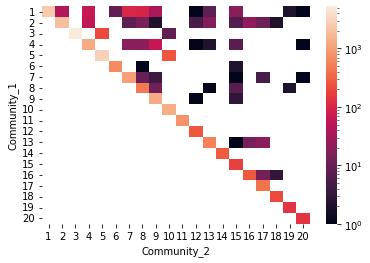

In [67]:
relation_matrix = relationship.pivot_table(index='Community_1',columns='Community_2',values='count')
sns.heatmap(relation_matrix,norm = LogNorm())

## India

In [69]:
fig = go.Figure()

fig.add_trace(go.Box(x = datamov3.Movie_release_year,name = '3'))
fig.add_trace(go.Box(x = datamov5.Movie_release_year,name = '5'))
fig.add_trace(go.Box(x = datamov10.Movie_release_year,name = '10'))

fig.update_layout(title = 'Distribution of movies over time for the Indian communities',template = 'plotly_white')
fig.update_xaxes(title = 'years')
fig.update_yaxes(title = 'community')
fig.show()

#fig.write_html('C:/Users/Public/ADA2022/weloic.github.io/_includes/india_time.html')

In [70]:
print(stats.ttest_ind(datamov3.Movie_release_year.dropna(),datamov5.Movie_release_year.dropna()))
print(stats.ttest_ind(datamov10.Movie_release_year.dropna(),datamov5.Movie_release_year.dropna()))
print(stats.ttest_ind(datamov3.Movie_release_year.dropna(),datamov10.Movie_release_year.dropna()))

Ttest_indResult(statistic=-6.062525433826842, pvalue=1.4108695631365665e-09)
Ttest_indResult(statistic=9.283480718604073, pvalue=2.4365309232416606e-20)
Ttest_indResult(statistic=-15.074374794060214, pvalue=2.5498741497399483e-50)


[('Drama', 2335), ('World cinema', 1558), ('Romance Film', 1132), ('Bollywood', 1077)]
[('Drama', 1773), ('Romance Film', 757), ('Action', 717), ('World cinema', 620)]
[('Drama', 957), ('Action', 388), ('Romance Film', 289), ('Comedy', 237)]


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Public/ADA2022/weloic.github.io/_includes/india_genre.svg'

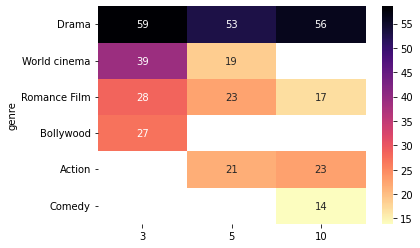

In [71]:
n = 4

first_genres = pd.DataFrame(columns=['genre'])
for i in [3,5,10]:
    genres = Counter([x for y in vars()['datamov' + str(i)]['Movie_genres'].values for x in y]).most_common(n)
    print(genres)
    genres = pd.DataFrame(data=genres, columns=['genre',str(i)])
    first_genres = first_genres.merge(genres,how='outer',on='genre')
    normalization = len(vars()['datamov' + str(i)])
    first_genres[str(i)]= first_genres[str(i)].apply(lambda x : x/normalization*100)

first_genres.set_index(['genre'],inplace = True)
plot = sns.heatmap(data=first_genres,cmap = 'magma_r',annot=True)
fig = plot.get_figure()
fig.savefig("C:/Users/Public/ADA2022/weloic.github.io/_includes/india_genre.svg")

In [72]:
fig = px.imshow(first_genres,color_continuous_scale  = 'Aggrnyl_r', text_auto='.0f',labels={'color':'% movies'})
fig.update_yaxes(title = 'Genre')
fig.update_xaxes(title = 'Community')
fig.update_layout(title = 'Genre appearances in Indian communities', template = 'plotly_white')
fig.show()
fig.write_html('C:/Users/Public/ADA2022/weloic.github.io/_includes/india_genres.html')

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Public/ADA2022/weloic.github.io/_includes/india_genres.html'

[('Hindi Language', 3138), ('English Language', 346), ('Tamil Language', 228)]
[('Tamil Language', 1434), ('Telugu language', 988), ('Hindi Language', 520)]
[('Malayalam Language', 890), ('Tamil Language', 393), ('Telugu language', 147)]


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Public/ADA2022/weloic.github.io/_includes/india_language.png'

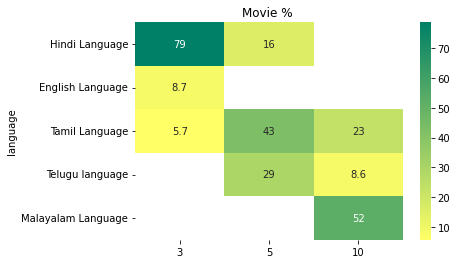

In [73]:
n = 3
first_languages = pd.DataFrame(columns=['language'])
for i in [3,5,10]:
    languages = Counter([x for y in vars()['datamov' + str(i)]['Movie_languages'].values for x in y]).most_common(n)
    print(languages)
    languages = pd.DataFrame(data=languages, columns=['language',str(i)])
    first_languages = first_languages.merge(languages,how='outer',on='language')
    normalization = len(vars()['datamov' + str(i)])
    first_languages[str(i)]= first_languages[str(i)].apply(lambda x : x/normalization*100)

first_languages.set_index(['language'],inplace = True)
plt.figure()
plot = sns.heatmap(data=first_languages,cmap = 'summer_r',annot=True)
plt.title('Movie % ')
fig = plot.get_figure()
fig.savefig("C:/Users/Public/ADA2022/weloic.github.io/_includes/india_language.png")

In [76]:
fig = px.imshow(first_languages,color_continuous_scale  = 'speed', text_auto='.0f',labels={'color':'% movies'})
fig.update_yaxes(title = 'language')
fig.update_xaxes(title = 'Community')
fig.update_layout(title = 'Languages of movies in Indian communities', template = 'plotly_white')
fig.update_traces(colorbar = {'thickness':1})
fig.show()
#fig.write_html('C:/Users/Public/ADA2022/weloic.github.io/_includes/india_languages.html')

In [75]:
data_actors[data_actors['Community'] == 10].head(3)

,Freebase_actor_ID,connectivity,Community,Wikidata_ID,actor_country_of_citizenship,actor_occupation,Actor_date_of_birth,actor_gender,Actor_name
4831,/m/048svj,902,10,Q6122250,India,"['actor', 'screenwriter', 'television actor', ...",1951-01-05,M,Jagathi Sreekumar
4832,/m/02fbpz,826,10,Q2050534,India,"['film actor', 'film producer', 'singer', 'pla...",1960-05-21,M,Mohanlal
4833,/m/02hkv5,776,10,Q2721855,India,"['film actor', 'film producer', 'screenwriter'...",1951-09-07,M,Mammootty


In [383]:
data_actors[data_actors['Community'] == 5].head(3)


,Freebase_actor_ID,connectivity,Community,Wikidata_ID,actor_country_of_citizenship,actor_occupation,Actor_date_of_birth,actor_gender,Actor_name
3374,/m/071wvh,1188,5,Q3765029,India,['comedian'],1956-02-01,M,Brahmanandam
3375,/m/09tqx3,845,5,Q1322453,India,"['film actor', 'film producer', 'film director...",1965-03-26,M,Prakash Raj
3376,/m/0dfjb8,679,5,Q3521977,India,"['film director', 'actor', 'screenwriter', 'fi...",1958-03-05,M,Nassar


In [384]:
data_actors[data_actors['Community'] == 3].head(3)

,Freebase_actor_ID,connectivity,Community,Wikidata_ID,actor_country_of_citizenship,actor_occupation,Actor_date_of_birth,actor_gender,Actor_name
2089,/m/04c636,1129,3,Q379604,India,"['film actor', 'politician']",1950-06-16,M,Mithun Chakraborty
2090,/m/05yvfd,969,3,Q312789,India,"['actor', 'comedian']",1958-09-03,M,Shakti Kapoor
2091,/m/0tj9,957,3,Q9570,India,"['film actor', 'film producer', 'singer', 'tel...",1942-10-11,M,Amitabh Bachchan


## Time Analysis

### distribution

Text(50.722222222222214, 0.5, 'Release year')

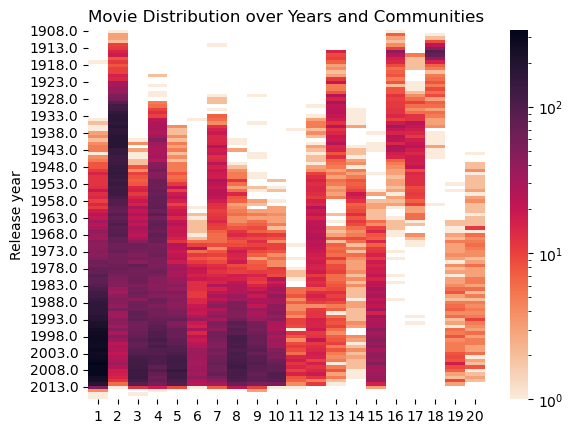

In [385]:
coms  =  np.arange(1,21)
movies_year_com = data_movies[coms.astype(str)]
movies_year_com['Movie_release_year'] = data_movies['Movie_release_year']
for y in coms.astype(str):
    movies_year_com[y] = movies_year_com[y].apply(lambda x : 1 if (x != 0) else  0)
movies_year_com = movies_year_com.groupby('Movie_release_year').agg('sum')
sns.heatmap(data=movies_year_com, norm=LogNorm(),cmap = 'rocket_r')
plt.title('Movie Distribution over Years and Communities')
plt.ylabel('Release year')

In [402]:
fig = px.imshow(np.log10(movies_year_com),y=movies_year_com.index,color_continuous_scale  = 'amp',labels={'color':'log nb movies'})
fig.update_yaxes(title = 'Release year')
fig.update_xaxes(title = 'Community')
fig.update_layout(title = 'Movie distribution over years and communities', template = 'plotly_white',height=600,width = 800)
fig.show()
fig.write_html('C:/Users/Public/ADA2022/weloic.github.io/_includes/movies_time_dist.html')

### The beginning of cinema 

In [387]:
datamov2.sort_values(by = 'Movie_release_year').head(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_languages,Movie_countries,Movie_genres,Movie_release_year,1,2,3,...,11,12,13,14,15,16,17,18,19,20
7636,19268430,/m/04lfsrt,The Call of the Wild,[English Language],[United States of America],"[Short Film, Silent film, Action]",1908.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
13014,73413,/m/0jqdm,A Corner in Wheat,[English Language],[United States of America],"[Silent film, Social problem film, Indie, Blac...",1909.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2018,9588217,/m/02pk_p8,The Sealed Room,[Silent film],[United States of America],"[Silent film, Horror, Indie, Black-and-white, ...",1909.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,0.0,0.0
11014,18230568,/m/04cyynz,In Little Italy,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Drama, Black-and-white]",1909.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
3207,14973616,/m/03h3dzx,Head Over Heels,[English Language],[United States of America],"[Short Film, Silent film, Drama, Indie, Comedy]",1910.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [388]:
datamov16.sort_values(by = 'Movie_release_year').head(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_languages,Movie_countries,Movie_genres,Movie_release_year,1,2,3,...,11,12,13,14,15,16,17,18,19,20
7636,19268430,/m/04lfsrt,The Call of the Wild,[English Language],[United States of America],"[Short Film, Silent film, Action]",1908.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
2018,9588217,/m/02pk_p8,The Sealed Room,[Silent film],[United States of America],"[Silent film, Horror, Indie, Black-and-white, ...",1909.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,0.0,0.0
11014,18230568,/m/04cyynz,In Little Italy,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Drama, Black-and-white]",1909.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
26530,13289708,/m/03c0nt6,The Red Man's View,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Western, Black-and-w...",1909.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
541,6735825,/m/0gl9t3,The Death Disc: A Story of the Cromwellian Period,[],[United States of America],"[Short Film, Silent film, Drama, Indie, Black-...",1909.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0


In [389]:
datamov18.sort_values(by = 'Movie_release_year').head(5)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_languages,Movie_countries,Movie_genres,Movie_release_year,1,2,3,...,11,12,13,14,15,16,17,18,19,20
2018,9588217,/m/02pk_p8,The Sealed Room,[Silent film],[United States of America],"[Silent film, Horror, Indie, Black-and-white, ...",1909.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,0.0,0.0
10042,13295592,/m/047gn31,Ramona,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Drama, Indie, Black-...",1910.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
6285,28777800,/m/0ddd49b,The Englishman and the Girl,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Comedy]",1910.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0
2935,7253646,/m/0kv22j,The Buddhist Priestess,[English Language],[United States of America],"[Short Film, Silent film, Drama, Indie, Black-...",1911.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
22815,7253406,/m/0kv210,Flames and Fortune,[English Language],[United States of America],"[Short Film, Silent film, Drama, Indie, Black-...",1911.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0


In [390]:
print(Counter([x for y in datamov18['Movie_countries'].values for x in y]).most_common())
print(Counter([x for y in datamov18['Movie_languages'].values for x in y]).most_common())

[('United States of America', 403), ('United Kingdom', 2), ('Soviet Union', 1), ('England', 1)]
[('English Language', 355), ('Silent film', 193), ('French Language', 1), ('Ukrainian Language', 1), ('American English', 1)]


In [391]:
features_movies.iloc[17]

Unnamed: 0                                          17
Community                                           18
1st Movie_genre                            Silent film
1st Movie_genre %                            84.708738
2nd Movie_genre                        Black-and-white
2nd Movie_genre %                            77.669903
3rd Movie_genre                             Short Film
3rd Movie_genre %                            65.533981
4th Movie_genre                                  Drama
4th Movie_genre %                            59.466019
5th Movie_genre                                  Indie
5th Movie_genre %                            49.514563
1st Movie_country             United States of America
1st Movie_country %                           0.990172
2nd Movie_country                       United Kingdom
2nd Movie_country %                           0.004914
3rd Movie_country                         Soviet Union
3rd Movie_country %                           0.002457
1st Movie_

In [392]:
features.iloc[17]

Community                                 18
Males_%                                 52.0
Females_%                               48.0
1st_country         United States of America
1st_country_%                           87.5
2nd_country                           Canada
2nd_country_%                       6.944444
3rd_country                          Germany
3rd_country_%                       2.777778
1st_occupation                      director
1st_occupation_%                   15.178571
2nd_occupation                        writer
2nd_occupation_%                        12.5
3rd_occupation                      producer
3rd_occupation_%                    5.357143
Name: 17, dtype: object

In [416]:
data_actors[data_actors['Community']==18].head(20)

,Freebase_actor_ID,connectivity,Community,Wikidata_ID,actor_country_of_citizenship,actor_occupation,Actor_date_of_birth,actor_gender,Actor_name
5879,/m/0krz_9,302,18,Q2960968,United States of America,"['actor', 'film actor']",1881-05-30,F,Charlotte Burton
5880,/m/0kr_7z,286,18,Q5673686,United States of America,"['actor', 'film actor']",1871-03-29,M,Harry von Meter
5881,/m/0ks01m,270,18,Q3157301,United States of America,['actor'],1883-11-18,M,Jack Richardson
5882,/m/0kr_01,241,18,Q526779,United States of America,"['actor', 'film actor']",1893-05-26,F,Vivian Rich
5883,/m/0krz_p,238,18,Q3263782,United States of America,"['stage actor', 'film actor']",1867-08-08,F,Louise Lester
5884,/m/0krxsd,148,18,Q3098625,United States of America,"['film director', 'actor', 'stage actor', 'fil...",1884-04-28,M,William Garwood
5885,/m/0kr_9g,94,18,Q391236,United States of America,"['actor', 'screenwriter', 'film director']",1879-08-28,M,Sydney Ayres
5886,/m/0kr_bl,84,18,Q7169721,Canada,['actor'],1877-04-24,M,Perry Banks
5887,/m/0ks551,81,18,Q2884883,United States of America,"['actor', 'film actor', 'stage actor', 'film d...",1880-08-08,M,Edward Coxen
5888,/m/0ks7nw,77,18,Q5338503,United States of America,"['actor', 'film actor']",1890-11-25,F,Edith Borella


In [393]:
Counter([x for y in datamov11['Movie_genres'].values for x in y]).most_common()

[('Animation', 182),
 ('Japanese Movies', 170),
 ('Anime', 161),
 ('Action', 101),
 ('Fantasy', 87),
 ('Science Fiction', 78),
 ('Adventure', 55),
 ('World cinema', 44),
 ('Comedy', 40),
 ('Family Film', 36),
 ('Drama', 31),
 ('Childrens', 27),
 ('Thriller', 21),
 ('Action/Adventure', 20),
 ('Animated cartoon', 17),
 ('Fantasy Adventure', 16),
 ('Romance Film', 14),
 ('Short Film', 13),
 ('Childrens/Family', 11),
 ('Comedy film', 9),
 ('Martial Arts Film', 9),
 ('Computer Animation', 8),
 ('Mystery', 8),
 ('Horror', 7),
 ('Childrens Fantasy', 7),
 ('Family-Oriented Adventure', 6),
 ('Fantasy Comedy', 5),
 ('Future noir', 5),
 ('Western', 4),
 ('Sports', 4),
 ('Coming of age', 3),
 ('Crime Thriller', 3),
 ('Indie', 3),
 ('Doomsday film', 2),
 ('Psychological thriller', 2),
 ('Dystopia', 2),
 ('LGBT', 2),
 ('Parody', 2),
 ('Chinese Movies', 2),
 ('Samurai cinema', 2),
 ('Romantic comedy', 2),
 ('Black-and-white', 2),
 ('Television movie', 1),
 ('Comedy-drama', 1),
 ('Supernatural', 1),
 

In [394]:
alice = ['/m/03dglc','/m/0crd1h6','/m/0crf95t','/m/012brhdl','/m/03cr4q9','/m/04myvv3','/m/03yn1b0','/m/080c485','/m/0_g606b','/m/0135xbrf','/m/05c4fw0','/m/0h54mgf']
all_movies[all_movies['Freebase_movie_ID'].isin(alice)]

,Unnamed: 0,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_languages,Movie_countries,Movie_genres,Movie_release_year
9291,9291,807258,/m/03dglc,La Fée aux Choux,[],[France],"[Silent film, Indie, Black-and-white, Short Fi...",1896.0
9713,9713,14019515,/m/03cr4q9,Esmeralda,[French Language],[France],"[Short Film, Silent film, Drama, Black-and-white]",1905.0
15365,15365,24463054,/m/080c485,Falling Leaves,[English Language],[United States of America],"[Short Film, Drama]",1912.0
21565,21565,28372044,/m/0crf95t,Danse serpentine,[],[France],"[Short Film, Silent film]",1896.0
42080,42080,19514976,/m/04myvv3,The Consequences of Feminism,[],[France],"[Short Film, Comedy film]",1906.0
55688,55688,16690709,/m/03yn1b0,Algie the Miner,[English Language],[United States of America],"[LGBT, Short Film, Silent film, Black-and-white]",1912.0
72614,72614,28371285,/m/0crd1h6,Le chiffonnier,[Silent film],[France],"[Short Film, Silent film]",1896.0
74675,74675,32946863,/m/0h54mgf,The Shooting of Dan McGrew,[],[],[Silent film],1915.0
77064,77064,21112004,/m/05c4fw0,Matrimony's Speed Limit,[English Language],[United States of America],"[Short Film, Silent film, Comedy, Slapstick]",1913.0


In [422]:
character_metadata[character_metadata['Actor_name'] == 'Trigger']

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,actor_gender,Actor_height_(in_meters),Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character/actor_map_ID,Freebase_character_ID,Freebase_actor_ID
7027,23691080,/m/06zp8lv,1944,NaN,NaN,M,NaN,NaN,Trigger,NaN,/m/0dk087b,NaN,/m/05pg6q


### Community 2

In [4]:
gender2 = gender_rolling[gender_rolling['Community']==2]
gender2 = gender2.pivot_table(values='rolling_average_ratio', index='year', columns='actor_gender',aggfunc='sum')

In [459]:
age_rolling2 = age_rolling[age_rolling['Community']==2]
age_rolling2

,Unnamed: 0,year,Community,average_age,rolling_average_age
1,1,1908,2,31.000000,NaN
21,21,1909,2,23.666667,0.000000
41,41,1910,2,29.500000,28.387143
61,61,1911,2,23.000000,34.677818
81,81,1912,2,25.222222,37.532809
...,...,...,...,...,...
2081,2081,2012,2,67.909091,0.000000
2101,2101,2013,2,68.500000,0.000000
2121,2121,2014,2,0.000000,33.920952
2141,2141,2015,2,0.000000,45.172222


In [7]:
fig = go.Figure()

fig.add_trace(go.Bar( x=gender2.index, y=1 -gender2['F'],name = 'male',marker={'color':color_dict['male_%']}))
fig.add_trace(go.Bar( x=gender2.index, y = gender2['F'],name = 'female',marker={'color':color_dict['female_%']}))

fig.update_layout(height = 300, title_text="Gender Distribution over the years for Community 2")
fig.update_layout(barmode = 'stack',template = 'plotly_white')

fig.show()
fig.write_html('C:/Users/Public/ADA2022/weloic.github.io/_includes/gender_2.html')

In [469]:
import statsmodels.formula.api as smf
gender2 = gender2.reset_index()
mod = smf.ols(formula='F ~ year', data=gender2) 
np.random.seed(2) 
res = mod.fit()  
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      F   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.6093
Date:                Fri, 23 Dec 2022   Prob (F-statistic):              0.437
Time:                        17:29:47   Log-Likelihood:                 21.199
No. Observations:                 109   AIC:                            -38.40
Df Residuals:                     107   BIC:                            -33.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4536      1.201     -0.378      0.706      -2.834       1.927
year           0.0005      0.001      0.781      0.437      -0.001       0.002
==============================================================================
Omnibus:                        4.959   Durbin-Watson:                   1.484
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                3.570
Skew:                          -0.301   Prob(JB):                        0.168
Kurtosis:                       2.350   Cond. No.                     1.22e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [461]:
fig = go.Figure()

fig.add_trace(go.Bar( x=age_rolling2['year'], y=age_rolling2['rolling_average_age'],name = 'average age'))

fig.update_layout(height = 600, title_text="Average age over the years for Community 2")
fig.update_layout(barmode = 'stack',template = 'plotly_white')

fig.show()
fig.write_html('C:/Users/Public/ADA2022/weloic.github.io/_includes/gender_2.html')

# Genre of movies

In [396]:
len(Counter([x for y in all_movies['Movie_genres'].values for x in y]).most_common())

363

### main genres in each community

<AxesSubplot:ylabel='genre'>

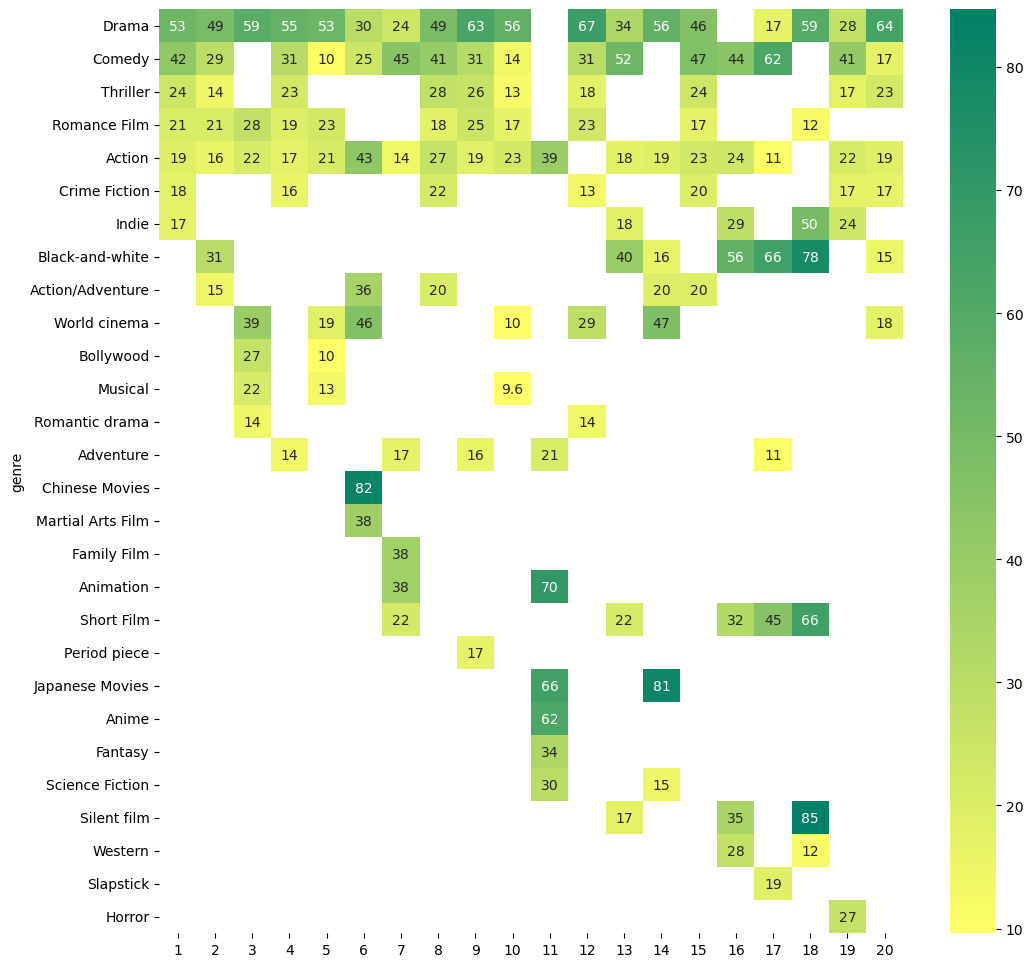

In [397]:
n = 7

first_genres = pd.DataFrame(columns=['genre'])
for i in range(1,21):
    genres = Counter([x for y in vars()['datamov' + str(i)]['Movie_genres'].values for x in y]).most_common(n)
    genres = pd.DataFrame(data=genres, columns=['genre',str(i)])
    first_genres = first_genres.merge(genres,how='outer',on='genre')
    normalization = len(vars()['datamov' + str(i)])
    first_genres[str(i)]= first_genres[str(i)].apply(lambda x : x/normalization*100)

first_genres.set_index(['genre'],inplace = True)
plt.figure(figsize=(12,12))
sns.heatmap(data=first_genres,cmap = 'summer_r',annot=True)

In [403]:
n = 5

first_genres = pd.DataFrame(columns=['genre'])
for i in range(1,21):
    genres = Counter([x for y in vars()['datamov' + str(i)]['Movie_genres'].values for x in y]).most_common(n)
    genres = pd.DataFrame(data=genres, columns=['genre',str(i)])
    first_genres = first_genres.merge(genres,how='outer',on='genre')
    normalization = len(vars()['datamov' + str(i)])
    first_genres[str(i)]= first_genres[str(i)].apply(lambda x : x/normalization*100)

first_genres.set_index(['genre'],inplace = True)

fig = px.imshow(first_genres,color_continuous_scale  = 'Aggrnyl_r',labels={'color':'movies %'},text_auto='.0f')
fig.update_yaxes(title = 'Release year')
fig.update_xaxes(title = 'Community')
fig.update_layout(title = 'Genre appearance in movies', template = 'plotly_white',height = 1000)
fig.show()
fig.write_html('C:/Users/Public/ADA2022/weloic.github.io/_includes/movies_genres_matrix.html')

In [404]:
datamov17

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_languages,Movie_countries,Movie_genres,Movie_release_year,1,2,3,...,11,12,13,14,15,16,17,18,19,20
101,14739568,/m/03gw63h,Hula-La-La,[English Language],[United States of America],"[Short Film, Comedy, Black-and-white, Slapstick]",1951.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0
114,21236198,/m/05c4c72,Thief of Damascus,[English Language],[United States of America],"[Romance Film, Fantasy, Adventure]",1952.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
174,44218,/m/0c1p3,San Francisco,[English Language],[United States of America],"[Disaster, Romance Film, Drama, Natural disast...",1936.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
243,24051028,/m/07kgp1w,No Time for Sergeants,[English Language],[United States of America],"[Slapstick, Drama, Comedy, Black-and-white, Fi...",1958.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
244,14734420,/m/03gvzxy,Pies and Guys,[English Language],[United States of America],"[Short Film, Comedy, Black-and-white]",1958.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27113,8004497,/m/026n72t,Rhythm and Weep,[English Language],[United States of America],"[Short Film, Comedy, Black-and-white, Slapstick]",1946.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
27137,3941009,/m/0b7v0f,The Man They Could Not Hang,[English Language],[United States of America],"[Horror, Black-and-white]",1939.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
27146,6736424,/m/0glc67,Beer and Pretzels,[English Language],[United States of America],"[Short Film, Screwball comedy, Comedy of manne...",1933.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0
27155,14738984,/m/03gw5m9,Studio Stoops,[English Language],[United States of America],"[Short Film, Comedy, Black-and-white]",1950.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0
